<a href="https://colab.research.google.com/github/DiegoPincheiraIb/Experiencias_EL5206/blob/master/Proyecto_Imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final Area Imagenes - Luckas Diaz y Diego Pincheira

El objetivo de este proyecto final es desarrollar e implementar un algoritmo de búsqueda de imágenes similares basado en su contenido (Content Based Image Retrieval, CBIR). Para el desarrollo de este proyecto debe descargar la base de datos INRIA Holidays dataset. Debe descargar los archivos jpg1.tar.gz y jpg2.tar.gz.

Link de para descargar: http://lear.inrialpes.fr/people/jegou/data.php

Las imágenes de la base de datos sólo se pueden utilizar en este proyecto académico. Para cualquier otro uso se debe referenciar el trabajo: Herve Jegou, Matthijs Douze and Cordelia Schmid, "Hamming Embedding and Weak geometry consistency for large scale image search", Proceedings of the 10th European conference on Computer vision, October, 2008.

## Imports

In [3]:
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

import skimage.io as io
from skimage import color, io, exposure
from skimage.feature import hog

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
import numpy as np
from IPython.display import clear_output
import cv2
from google.colab.patches import cv2_imshow
from scipy import ndimage, misc
!pip install ipython-autotime
%load_ext autotime

time: 161 µs (started: 2020-12-25 21:09:48 +00:00)


## Cargar datos a Colab

### Desde disco local

Aqui se deben cargar los archivos jpg1.tar.gz y jpg2.tar.gz

In [ ]:
from google.colab import files
uploaded = files.upload()

### Desde Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 27.2 s (started: 2020-12-25 21:09:48 +00:00)


In [3]:
!ls

drive  sample_data
time: 124 ms (started: 2020-12-24 18:42:45 +00:00)


In [5]:
%cd drive/MyDrive/Proyecto-Imagenes/

/content/drive/MyDrive/Proyecto-Imagenes
time: 13.8 ms (started: 2020-12-25 21:10:17 +00:00)


In [2]:
!ls

sample_data


In [8]:
!mkdir 'jpg1'
!mkdir 'jpg2'

In [ ]:
!tar -xvf  'jpg1.tar.gz' -C 'jpg1'
!tar -xvf  'jpg2.tar.gz' -C 'jpg2'
clear_output()
print('listo!')

In [11]:
!ls

jpg1  jpg1.tar.gz  jpg2  jpg2.tar.gz
time: 27.9 ms (started: 2020-12-24 23:41:23 +00:00)


## Obtener paths de imagenes

In [6]:
path_jpg1 = 'jpg1/jpg'
path_jpg2 = 'jpg2/jpg'
Listado_jpg1 = os.listdir(path_jpg1)
Listado_jpg2 = os.listdir(path_jpg2)
print(Listado_jpg1)
print(Listado_jpg2)

['100000.jpg', '100001.jpg', '100101.jpg', '100200.jpg', '100100.jpg', '100201.jpg', '100301.jpg', '100302.jpg', '100300.jpg', '100002.jpg', '100401.jpg', '100400.jpg', '100701.jpg', '100503.jpg', '100601.jpg', '100501.jpg', '100600.jpg', '100700.jpg', '100500.jpg', '100502.jpg', '100902.jpg', '100800.jpg', '100801.jpg', '101001.jpg', '101101.jpg', '101100.jpg', '100900.jpg', '101200.jpg', '100901.jpg', '101000.jpg', '101201.jpg', '101503.jpg', '101501.jpg', '101504.jpg', '101404.jpg', '101300.jpg', '101402.jpg', '101401.jpg', '101301.jpg', '101500.jpg', '101502.jpg', '101400.jpg', '101403.jpg', '102000.jpg', '101901.jpg', '101600.jpg', '101800.jpg', '101701.jpg', '101700.jpg', '102001.jpg', '101702.jpg', '101601.jpg', '102100.jpg', '101801.jpg', '101900.jpg', '102302.jpg', '102201.jpg', '102101.jpg', '102301.jpg', '102200.jpg', '102202.jpg', '102300.jpg', '102402.jpg', '102700.jpg', '102601.jpg', '102400.jpg', '102800.jpg', '102501.jpg', '102801.jpg', '102500.jpg', '102303.jpg', '1027

## Convertir a Escalas de Grises

In [8]:
def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]

time: 2.28 ms (started: 2020-12-25 21:11:12 +00:00)


In [27]:
def Imagenes_Gris_Resize(Path_Obj,Listado_Obj, Factor_Reescala_Obj = 1):
  Lista_Completa = []
  #Lista_1, Lista_2, Lista_3, Lista_4 = split_list(Listado_Obj, wanted_parts=4)
  if Factor_Reescala_Obj < 1:
    for imagen in Listado_Obj:
      Lista_Completa.append(cv2.resize(cv2.imread(Path_Obj + '/' + imagen),None,fx=Factor_Reescala_Obj,fy=Factor_Reescala_Obj))
  else:
    for imagen in Listado_Obj:
      Lista_Completa.append(cv2.imread(Path_Obj + '/' + imagen))
  return Lista_Completa

time: 5.11 ms (started: 2020-12-25 21:56:17 +00:00)


### Jpg1

In [28]:
Listado_jpg1_Gris = Imagenes_Gris_Resize(path_jpg1, Listado_jpg1, 0.5)

time: 1min 10s (started: 2020-12-25 21:56:20 +00:00)


### Jpg2

In [29]:
Listado_jpg2_Gris = Imagenes_Gris_Resize(path_jpg2, Listado_jpg2, 0.5)

time: 1min 25s (started: 2020-12-25 21:57:31 +00:00)


## VGG 16

In [15]:
model = VGG16(weights='imagenet', include_top=False)

time: 646 ms (started: 2020-12-25 21:42:20 +00:00)


In [40]:
def Calculo_Vector_Caract(Img_Obj, Tipo_Vector):
  if Tipo_Vector == 'hog':
    Feature_Vector_Obj = hog(Img_Obj, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), feature_vector =True)
  else:
    Img_Obj = image.img_to_array(Img_Obj)
    Img_Obj = np.expand_dims(Img_Obj, axis=0)
    Img_Obj = preprocess_input(Img_Obj)
    Feature_Vector_Obj = model.predict(Img_Obj)
  return Feature_Vector_Obj

time: 18.6 s (started: 2020-12-25 22:02:10 +00:00)


In [ ]:
img = Listado_jpg1_Gris[1]

time: 725 µs (started: 2020-12-25 22:00:24 +00:00)


In [41]:
Hola = Calculo_Vector_Caract(img,'cnn')

time: 17.7 s (started: 2020-12-25 22:07:14 +00:00)


## Distancias:

Chi-Cuadrado. Fuente: https://www.geeksforgeeks.org/chi-square-distance-in-python/

In [ ]:
def chi2_distance(A, B): 
  
    # compute the chi-squared distance using above formula 
    chi = 0.5 * np.sum([((a - b) ** 2) / (a + b)  
                      for (a, b) in zip(A, B)]) 
  
    return chi 

In [15]:
# Str_Dist = 'eucl', 'chi', 'cos'

def Funcion_Distancia(Vect_1, Vect_2, Str_Dist = 'eucl'):
  if Str_Dist == 'eucl':
    Distancia = euclidean_distances(Vect_1, Vect_2)
  elif Str_Dist == 'cos':
    Distancia = cosine_distances(Vect_1, Vect_2)
  else:
    Distancia = chi2_distance(Vect_1, Vect_2)
  return Distancia

time: 323 ms (started: 2020-12-25 03:14:32 +00:00)


In [ ]:
# Str_Dist = 'eucl', 'chi', 'cos'
def Busqueda(Feature_Vector_Obj, Database_Obj, Str_Dist = 'eucl'):
  Similitudes = []
  for imagen in Database_Obj:
    Distancia = Funcion_Distancia(Feature_Vector_Obj, imagen,Str_Dist)
    Similitudes.append(Distancia)
  return Similitudes

# Obsoleto

## HOG

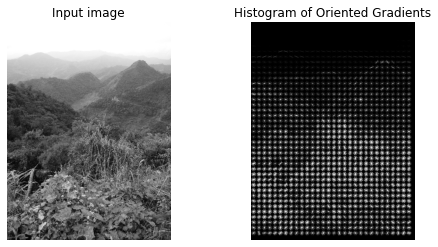

time: 447 ms (started: 2020-12-24 21:01:42 +00:00)


In [ ]:
fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True, feature_vector =True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

VGG

In [ ]:

img_path = path_jpg1 + '/' + Listado_jpg1[1]
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

In [ ]:
print(len(Listado_jpg1_Gris))

812
time: 2.51 ms (started: 2020-12-25 00:34:57 +00:00)


In [ ]:
Listado_jpg1_1, Listado_jpg1_2, Listado_jpg1_3, Listado_jpg1_4 = split_list(Listado_jpg1, wanted_parts=4)
Listado_jpg1_Gris = []
Factor_Reescala = 0.2

time: 2.24 ms (started: 2020-12-24 21:20:33 +00:00)


In [ ]:
for imagen in Listado_jpg1_1:
  Listado_jpg1_Gris.append(cv2.resize(cv2.imread(path_jpg1 + '/' + imagen,0),None,fx=Factor_Reescala,fy=Factor_Reescala))

time: 2min 58s (started: 2020-12-24 21:20:33 +00:00)


In [ ]:
for imagen in Listado_jpg1_2:
  Listado_jpg1_Gris.append(cv2.resize(cv2.imread(path_jpg1 + '/' + imagen,0),None,fx=Factor_Reescala,fy=Factor_Reescala))

time: 2min 28s (started: 2020-12-24 21:23:31 +00:00)


In [ ]:
for imagen in Listado_jpg1_3:
  Listado_jpg1_Gris.append(cv2.resize(cv2.imread(path_jpg1 + '/' + imagen,0),None,fx=Factor_Reescala,fy=Factor_Reescala))

time: 2min 29s (started: 2020-12-24 21:26:00 +00:00)


In [ ]:
for imagen in Listado_jpg1_4:
  Listado_jpg1_Gris.append(cv2.resize(cv2.imread(path_jpg1 + '/' + imagen,0),None,fx=Factor_Reescala,fy=Factor_Reescala))

time: 2min 18s (started: 2020-12-24 21:28:29 +00:00)


### Jpg2

In [ ]:
Listado_jpg2_1, Listado_jpg2_2, Listado_jpg2_3, Listado_jpg2_4 = split_list(Listado_jpg2, wanted_parts=4)

time: 1.05 ms (started: 2020-12-24 18:52:36 +00:00)


In [ ]:
Listado_jpg2_Gris = []
for imagen in Listado_jpg2_1:
  Listado_jpg2_Gris.append(cv2.imread(path_jpg2 + '/' + imagen,0))

time: 10.2 s (started: 2020-12-24 19:04:18 +00:00)


In [ ]:
for imagen in Listado_jpg2_2:
  Listado_jpg2_Gris.append(cv2.imread(path_jpg2 + '/' + imagen,0))

time: 12.7 s (started: 2020-12-24 19:04:28 +00:00)


In [ ]:
for imagen in Listado_jpg2_3:
  Listado_jpg2_Gris.append(cv2.imread(path_jpg2 + '/' + imagen,0))

time: 8.84 s (started: 2020-12-24 19:04:41 +00:00)


In [ ]:
for imagen in Listado_jpg2_4:
  Listado_jpg2_Gris.append(cv2.imread(path_jpg2 + '/' + imagen,0))

time: 13.4 s (started: 2020-12-24 19:04:50 +00:00)
